In [16]:
!pip install -q "transformers>=4.41.2" "torch>=2.1" pillow matplotlib opencv-python "decord>=0.6" "imageio>=2.34" "imageio-ffmpeg>=0.4.9"

import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import imageio
from decord import VideoReader, cpu

# Check for GPU availability and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

✅ Using device: cpu


In [2]:

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, SamModel, SamProcessor

# Load GroundingDINO (Text-to-Box)
grounding_dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
grounding_dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)

# Load Original SAM (Box-to-Mask)
sam_model_id = "facebook/sam-vit-base" # <-- Open-access model
sam_model = SamModel.from_pretrained(sam_model_id).to(device)
sam_processor = SamProcessor.from_pretrained(sam_model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Helper functions to display the final mask overlay.
# ===============================================================
def show_mask(mask, ax, random_color=False):
    """Overlays a segmentation mask on a matplotlib axis."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # Blue with 60% opacity
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def display_image_with_masks(image, masks, title=""):
    """Displays the original image with segmentation masks overlaid."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    # The 'masks' tensor has a shape of (num_boxes, 3, height, width).
    # We loop through each detected box.
    for mask_set in masks:
        # For each box, SAM predicts 3 masks. We'll just display the first one.
        single_mask = mask_set[0]
        show_mask(single_mask.cpu().numpy(), plt.gca(), random_color=True)
    plt.title(title)
    plt.axis('off')
    plt.show()


--- Starting Text-Driven Image Segmentation ---
Image loaded from URL.
 Text Prompt: 'both cat.'
 Running GroundingDINO to find the object...
 Found 1 instance(s) of 'both cat.'.
 Running SAM to generate segmentation masks...
 Mask generation complete.


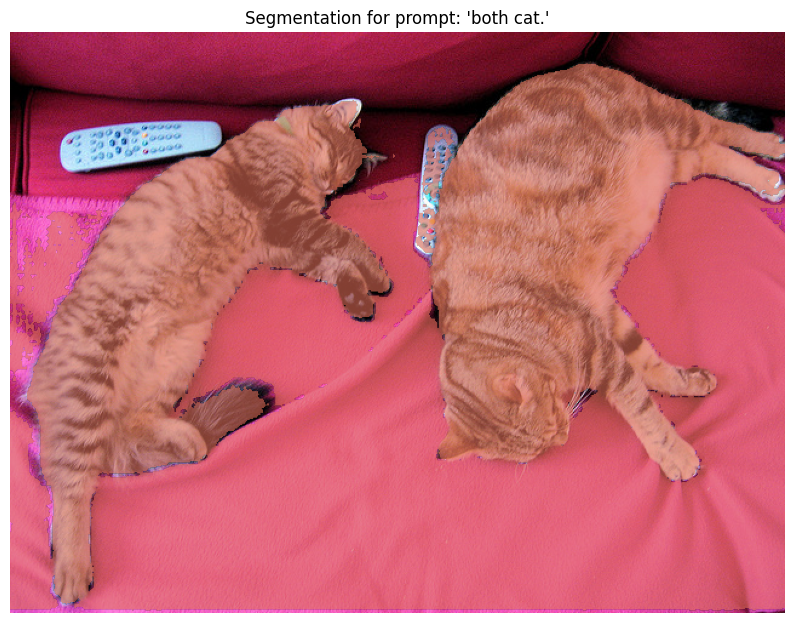

In [7]:
# ===============================================================
# 4. SINGLE IMAGE SEGMENTATION PIPELINE
# ===============================================================
print("\n--- Starting Text-Driven Image Segmentation ---")

# --- Step 1: Load Image ---
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_pil = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
print(f"Image loaded from URL.")

# --- Step 2: Accept a Text Prompt ---
text_prompt = "both cat."
print(f" Text Prompt: '{text_prompt}'")

# --- Step 3: Convert Text to Region Seeds (GroundingDINO) ---
print(" Running GroundingDINO to find the object...")
inputs = grounding_dino_processor(images=image_pil, text=text_prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = grounding_dino_model(**inputs)

#  FINAL CORRECTION: Call the function on the .image_processor attribute
results = grounding_dino_processor.image_processor.post_process_object_detection(
    outputs,
    target_sizes=[image_pil.size[::-1]],
    threshold=0.4
)

# Extract bounding boxes
boxes = results[0]["boxes"]
print(f" Found {len(boxes)} instance(s) of '{text_prompt}'.")


# --- Step 4: Feed Seeds to SAM ---
print(" Running SAM to generate segmentation masks...")
# Format boxes for SAM input
input_boxes = [[box.tolist()] for box in boxes]
sam_inputs = sam_processor(image_pil, input_boxes=input_boxes, return_tensors="pt").to(device)

# Generate masks
with torch.no_grad():
    sam_outputs = sam_model(**sam_inputs)

# Post-process masks
masks = sam_processor.image_processor.post_process_masks(
    sam_outputs.pred_masks.cpu(),
    sam_inputs["original_sizes"].cpu(),
    sam_inputs["reshaped_input_sizes"].cpu()
)[0]
print(" Mask generation complete.")

# --- Step 5: Display the Final Mask Overlay ---
display_image_with_masks(image_pil, masks, title=f"Segmentation for prompt: '{text_prompt}'")

In [14]:
import numpy as np

def get_bounding_box(mask):
    """
    Calculates the bounding box of a binary mask.
    The mask should be a 2D numpy array.
    """
    y_indices, x_indices = np.where(mask)
    if len(x_indices) == 0: # Handle cases where the mask is empty
        return [0, 0, 0, 0]
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # Return in [x_min, y_min, x_max, y_max] format
    return [int(x_min), int(y_min), int(x_max), int(y_max)]

In [17]:
# ===============================================================
# 5. (BONUS) VIDEO OBJECT SEGMENTATION (Final Corrected Version)
# ===============================================================
print("\n--- Starting Text-Driven Video Segmentation (Bonus) ---")

import cv2
import os
from google.colab import files

# --- Step 1: Upload Video From Your Computer ---
print(" KPlease upload a short video file from your computer.")
uploaded = files.upload()

if not uploaded:
    print("❌ No file was uploaded. Please run the cell again.")
else:
    video_path = list(uploaded.keys())[0]
    print(f"✅ User uploaded file: '{video_path}'")

    # --- Step 2: Perform Initial Segmentation on the First Frame ---
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Error: OpenCV could not open the uploaded video file.")
    else:
        ret, first_frame = cap.read()
        if not ret:
            print("❌ Error: Could not read the first frame.")
        else:
            first_frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
            first_frame_pil = Image.fromarray(first_frame_rgb)
            cap.release()

            # IMPORTANT: Change this prompt to match the object in YOUR video!
            video_text_prompt = "a dog."
            print(f"💬 Video Text Prompt: '{video_text_prompt}'")

            print("🔍 Running GroundingDINO on the first frame...")
            inputs = grounding_dino_processor(images=first_frame_pil, text=video_text_prompt, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = grounding_dino_model(**inputs)

            results = grounding_dino_processor.image_processor.post_process_object_detection(
                outputs, target_sizes=[first_frame_pil.size[::-1]], threshold=0.4
            )
            boxes = results[0]['boxes']

            if len(boxes) == 0:
                print(f"⚠️ No '{video_text_prompt}' found in the first frame. Cannot proceed.")
            else:
                print("🎨 Running SAM on the first frame...")
                input_boxes = [[boxes[0].tolist()]]
                sam_inputs = sam_processor(first_frame_pil, input_boxes=input_boxes, return_tensors="pt").to(device)
                with torch.no_grad():
                    sam_outputs = sam_model(**sam_inputs)
                masks = sam_processor.image_processor.post_process_masks(
                    sam_outputs.pred_masks.cpu(), sam_inputs["original_sizes"].cpu(), sam_inputs["reshaped_input_sizes"].cpu()
                )[0]
                prev_mask = masks[0]

                # --- Step 3: Propagate Mask Across Frames ---
                print("🏃 Propagating mask across video frames...")
                output_frames = []

                # The broken import line has been removed. We now use the helper function defined above.

                cap = cv2.VideoCapture(video_path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                for _ in tqdm(range(frame_count), desc="Video Frame Processing"):
                    ret, frame = cap.read()
                    if not ret: break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_pil = Image.fromarray(frame_rgb)

                    # Use our new helper function
                    bbox = get_bounding_box(prev_mask[0].numpy())
                    video_inputs = sam_processor(frame_pil, input_boxes=[[bbox]], return_tensors="pt").to(device)
                    with torch.no_grad():
                        video_outputs = sam_model(**video_inputs)

                    new_masks = sam_processor.image_processor.post_process_masks(
                        video_outputs.pred_masks.cpu(), video_inputs["original_sizes"].cpu(), video_inputs["reshaped_input_sizes"].cpu()
                    )[0]
                    prev_mask = new_masks[0]

                    frame_overlayed = frame_rgb.copy()
                    color_mask = np.array([30, 144, 255], dtype=np.uint8)
                    frame_overlayed[prev_mask[0].numpy().astype(bool)] = frame_overlayed[prev_mask[0].numpy().astype(bool)] * 0.4 + color_mask * 0.6
                    output_frames.append(frame_overlayed)

                cap.release()

                # --- Step 4: Save the Output Video ---
                if output_frames:
                    output_video_path = "output_segmented_video.mp4"
                    print(f"💾 Saving segmented video to {output_video_path}...")
                    imageio.mimsave(output_video_path, output_frames, fps=30)
                    print("✅ Video processing complete!")


--- Starting Text-Driven Video Segmentation (Bonus) ---
 KPlease upload a short video file from your computer.


Saving 2795691-uhd_3840_2160_25fps.mp4 to 2795691-uhd_3840_2160_25fps (1).mp4
✅ User uploaded file: '2795691-uhd_3840_2160_25fps (1).mp4'
💬 Video Text Prompt: 'a dog.'
🔍 Running GroundingDINO on the first frame...
🎨 Running SAM on the first frame...
🏃 Propagating mask across video frames...


Video Frame Processing:   0%|          | 0/154 [00:00<?, ?it/s]

💾 Saving segmented video to output_segmented_video.mp4...
✅ Video processing complete!
